# 240912 EDA 조금 도전

### Import Library

In [36]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import seaborn as sns
import matplotlib.pyplot as plt


### Load Data

In [45]:
path = "../data/"

train = pd.read_csv(path+"train.csv").assign(_type="train")
test = pd.read_csv(path+"test.csv").assign(_type="test")
submission = pd.read_csv(path+"test.csv")
df = pd.concat([train, test], axis=0)

In [46]:
prefixes = ["HOURLY_NETWORK-DATA_",
            "HOURLY_MARKET-DATA_PRICE-OHLCV_ALL_EXCHANGE_SPOT_BTC_USD",
            "HOURLY_MARKET-DATA_COINBASE-PREMIUM-INDEX",
            "HOURLY_MARKET-DATA_FUNDING-RATES_ALL_EXCHANGE",
            "HOURLY_MARKET-DATA_LIQUIDATIONS_ALL_EXCHANGE_ALL_SYMBOL",
            "HOURLY_MARKET-DATA_OPEN-INTEREST_ALL_EXCHANGE_ALL_SYMBOL",
            "HOURLY_MARKET-DATA_TAKER-BUY-SELL-STATS_ALL_EXCHANGE"]

file_names = [
    f for f in os.listdir(path)
    if any(f.startswith(prefix) for prefix in prefixes) and f.endswith(".csv")
]
display(file_names)
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(path+f) for f in file_names
}


for _file_name, _df in tqdm(file_dict.items()):
    _rename_rule = {
        col: f"{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


['HOURLY_NETWORK-DATA_TRANSACTIONS-COUNT.csv',
 'HOURLY_MARKET-DATA_TAKER-BUY-SELL-STATS_ALL_EXCHANGE.csv',
 'HOURLY_NETWORK-DATA_BLOCK-INTERVAL.csv',
 'HOURLY_NETWORK-DATA_ADDRESSES-COUNT.csv',
 'HOURLY_MARKET-DATA_COINBASE-PREMIUM-INDEX.csv',
 'HOURLY_MARKET-DATA_OPEN-INTEREST_ALL_EXCHANGE_ALL_SYMBOL.csv',
 'HOURLY_NETWORK-DATA_HASHRATE.csv',
 'HOURLY_NETWORK-DATA_BLOCKREWARD.csv',
 'HOURLY_NETWORK-DATA_SUPPLY.csv',
 'HOURLY_MARKET-DATA_FUNDING-RATES_ALL_EXCHANGE.csv',
 'HOURLY_MARKET-DATA_PRICE-OHLCV_ALL_EXCHANGE_SPOT_BTC_USD.csv',
 'HOURLY_NETWORK-DATA_BLOCK-COUNT.csv',
 'HOURLY_NETWORK-DATA_UTXO-COUNT.csv',
 'HOURLY_NETWORK-DATA_BLOCK-BYTES.csv',
 'HOURLY_NETWORK-DATA_FEES-TRANSACTION.csv',
 'HOURLY_NETWORK-DATA_TOKENS-TRANSFERRED.csv',
 'HOURLY_NETWORK-DATA_FEES.csv',
 'HOURLY_NETWORK-DATA_VELOCITY.csv',
 'HOURLY_NETWORK-DATA_DIFFICULTY.csv',
 'HOURLY_MARKET-DATA_LIQUIDATIONS_ALL_EXCHANGE_ALL_SYMBOL.csv']

100%|██████████| 20/20 [00:00<00:00, 33.34it/s]


### EDA

##### 누락 값 확인

In [39]:
# 누락된 값을 백분율로 나타내기
eda_df = df.loc[df["_type"] == "train"]
missing_values = eda_df.isnull().sum()
missing_percentage = (missing_values / len(eda_df)) * 100
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

transactions_count_mean        0.216895
block_interval                 0.216895
difficulty                     0.216895
fees_transaction_mean          0.216895
block_bytes                    0.216895
fees_transaction_mean_usd      0.216895
tokens_transferred_mean        0.216895
fees_block_mean                0.216895
fees_block_mean_usd            0.216895
fees_reward_percent            0.216895
coinbase_premium_gap           0.057078
coinbase_premium_index         0.057078
target                         0.000000
_type                          0.000000
addresses_count_receiver       0.000000
addresses_count_sender         0.000000
addresses_count_active         0.000000
taker_buy_sell_ratio           0.000000
taker_buy_ratio                0.000000
taker_sell_ratio               0.000000
taker_sell_volume              0.000000
taker_buy_volume               0.000000
ID                             0.000000
transactions_count_total       0.000000
blockreward_usd                0.000000


In [12]:
# len(sorted_missing_percentage[sorted_missing_percentage == 100.0].index)

# for idx, val in sorted_missing_percentage.items():
#     print(f'Index: {idx}, Value: {val}')

# eda_df = df.drop(sorted_missing_percentage[sorted_missing_percentage == 100.0].index, axis=1)

##### 레이블 분포

데이터 증강이나 뭐.. 처리를 해서도 실험을 해보아야겠다.

In [44]:
# 타겟 레이블 분포 -> 으으음 왜이랫!!!
eda_df["target"].value_counts()/len(eda_df)

target
2.0    0.419064
1.0    0.404566
3.0    0.091895
0.0    0.084475
Name: count, dtype: float64

##### 독립변수 간의 상관계수

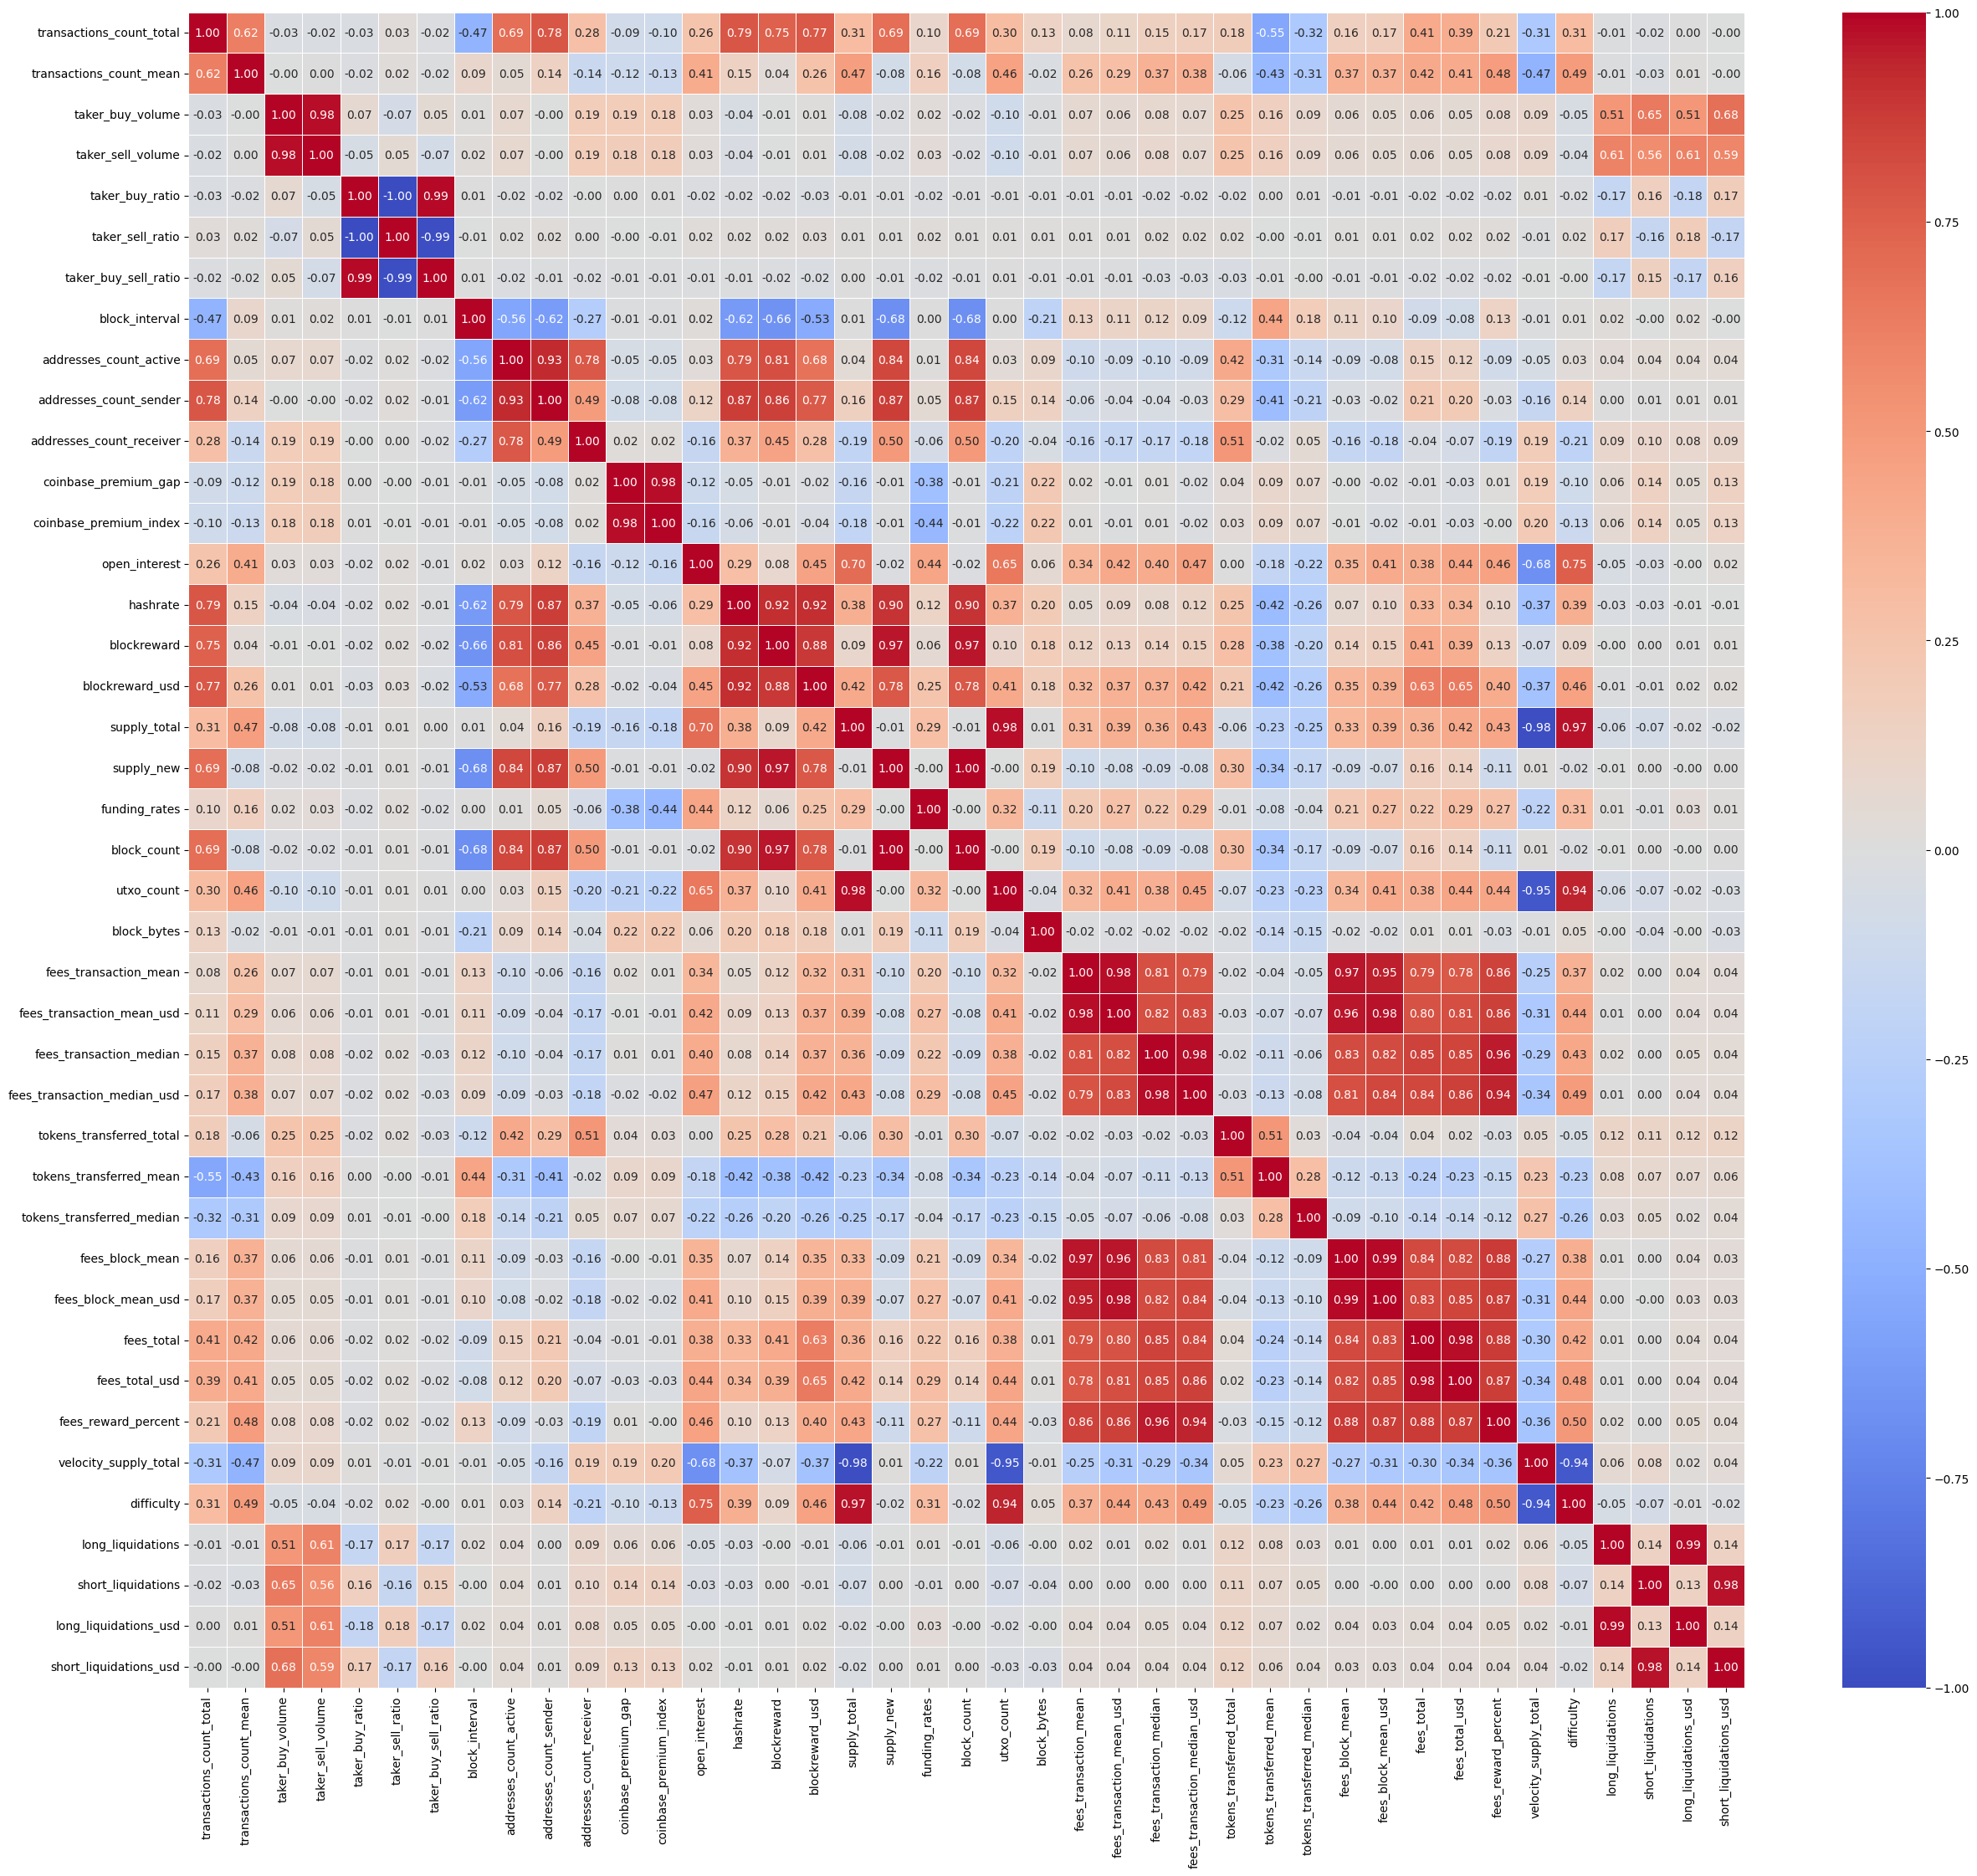

In [21]:
# 상관계수 확인
correlation_matrix = eda_df.iloc[:,3:].corr()

plt.figure(figsize=(30, 26))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

plt.show()

눈이 쪼꼼 아푸네요.. 모든 변수들에 대해 상관계수를 확인하고 싶었어요. 

같은 CSV 파일에서 가져온 컬럼들은 강한 상관관계를 보이는 것처럼 보이지만, 

이게 유리하게 작용할지는 모르겠네요.

도메인 지식을 잘 몰라서, 도메인 지식을 공부할 때 도움이 될 것 같네요.

##### 가격 변동에 따른 독립변수들의 변화 확인하기

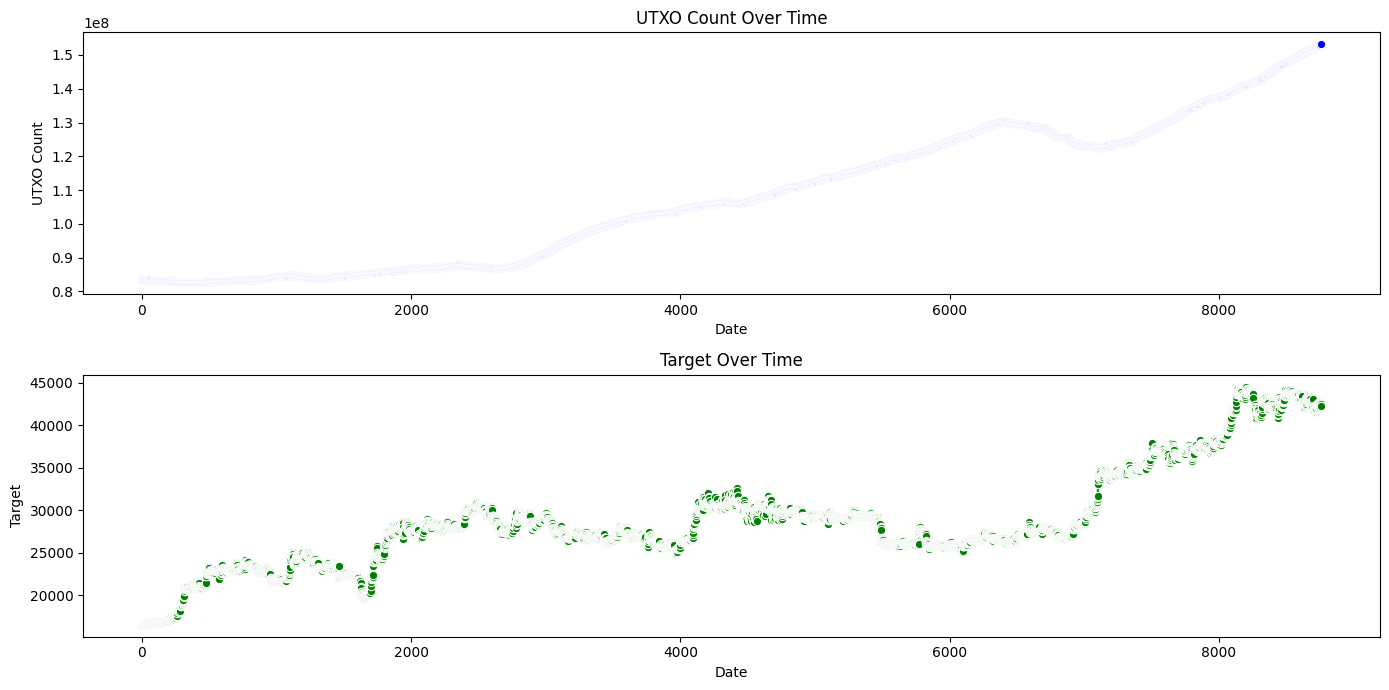

In [42]:

plt.figure(figsize=(14, 7))

# UTXO Count 시각화
plt.subplot(2, 1, 1)
sns.lineplot(data=eda_df, x=eda_df.index, y='utxo_count', marker='o', color='blue')
plt.title('UTXO Count Over Time')
plt.xlabel('Date')
plt.ylabel('UTXO Count')

# Target 시각화
plt.subplot(2, 1, 2)
sns.lineplot(data=eda_df, x=eda_df.index, y='close', marker='o', color='green')
plt.title('Target Over Time')
plt.xlabel('Date')
plt.ylabel('Target')

plt.tight_layout()
plt.show()


UTXO Count와 close 가격의 변동은 어때요??? 비슷해보이나요?

제가 생각하기에 시간이 지남에 따라 오르고 있는 것은 맞지만 

이것은 각 변수들의 독립적인 특징일 수도 있을 것 같다는 생각이 드네요.

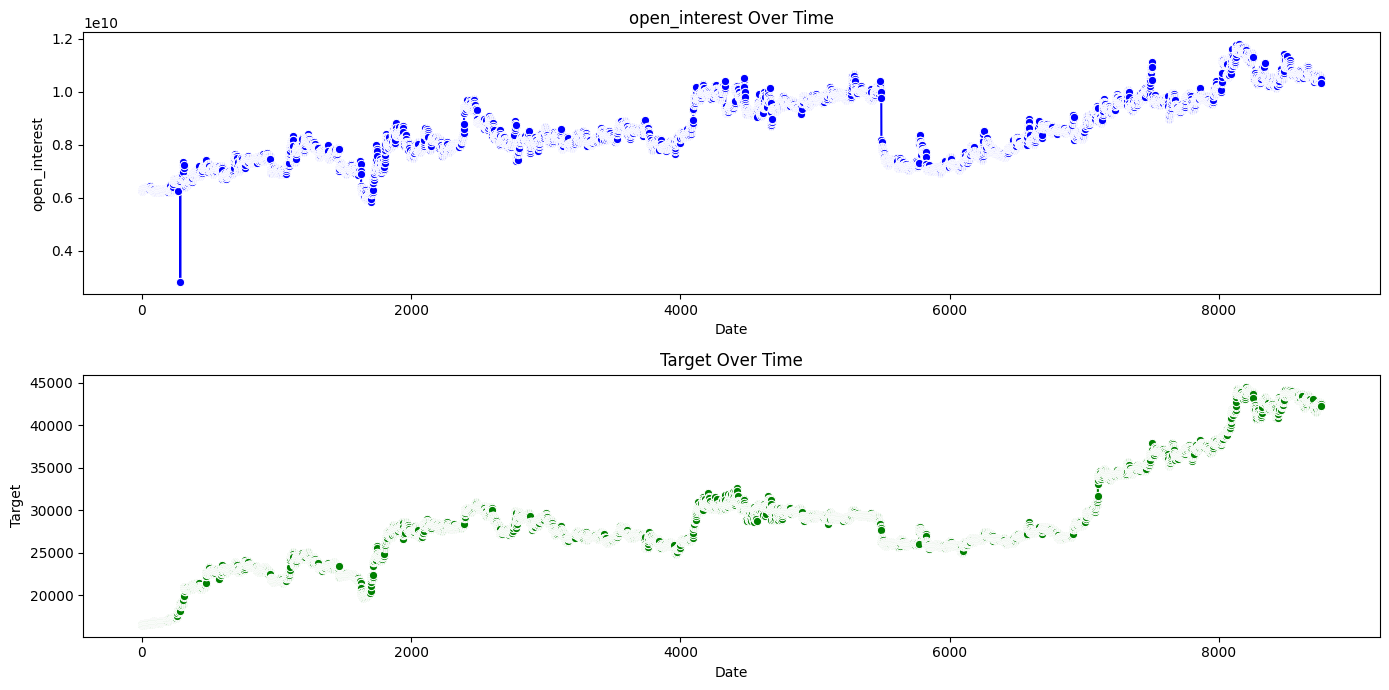

<Figure size 640x480 with 0 Axes>

In [43]:
plt.figure(figsize=(14, 7))

# UTXO Count 시각화
plt.subplot(2, 1, 1)
sns.lineplot(data=eda_df, x=eda_df.index, y='open_interest', marker='o', color='blue')
plt.title('open_interest Over Time')
plt.xlabel('Date')
plt.ylabel('open_interest')

# Target 시각화
plt.subplot(2, 1, 2)
sns.lineplot(data=eda_df, x=eda_df.index, y='close', marker='o', color='green')
plt.title('Target Over Time')
plt.xlabel('Date')
plt.ylabel('Target')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

open intereset와 close 가격의 변동은 

어때요??? 비슷해보이지 않나요? 

등락에 따라서 그래프 움직임이 좀 비슷해보여요

# *EDA 많이 못했는데, 도메인 지식을 더 공부한 뒤에 해볼 수 있을 것 같다.*